<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Chess Game Playing While Chitchatting by GPT-4 Agents

AutoGen offers conversable agents powered by LLM, tool, or human, which can be used to perform tasks collectively via automated chat. This framework allows tool use and human participation through multi-agent conversation.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

This notebook is modified based on https://github.com/ekzhu/FLAML/blob/evaluation/evaluation/chess/play_chess.ipynb

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [17]:
%pip install -U chess

Note: you may need to restart the kernel to use updated packages.


In [23]:
from typing import Dict, List, Annotated, Tuple
from autogen import config_list_from_json, UserProxyAgent, ConversableAgent
from autogen.agentchat.chat import Chat
import chess
import chess.svg
from IPython.display import display

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [19]:
config_list_gpt4 = config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

You can set the value of config_list in any way you prefer. Please refer to this [notebook](https://github.com/microsoft/autogen/blob/main/notebook/oai_openai_utils.ipynb) for full code examples of the different methods.

## Define Agents

We first define the agents. The player agents are powered by GPT-4 models.

In [20]:
sys_msg_tmpl = """Your name is {name} and you are a chess player.
You are playing against {opponent_name}.
You are playing as {color}.
When you make a move, you must first use the function "get_legal_moves" to get a list of legal moves and their scores,
and then use the function "make_move" to make a legal move.
After you make a move, you chit-chat about your move and communicate the move to your opponent.
Always address your opponent by name: "{opponent_name}, ...".
If you have no legal move, you say "resign" to resign the game.
Do not apologies."""

player_white = ConversableAgent(
    name="Player White",
    system_message=sys_msg_tmpl.format(name="Player White", opponent_name="Player Black", color="white"),
    llm_config={"temperature": 0.3, "cache_seed": 2, "config_list": config_list_gpt4},
    is_termination_msg=lambda msg: msg.get("content").strip().lower() == "resign",
)
proxy_black = UserProxyAgent(
    name="Player Black (Proxy)",
    human_input_mode="NEVER",
    is_termination_msg=lambda msg: msg.get("content") is not None
    and msg.get("content").strip().lower().startswith("player black"),
)

We define one proxy agent for each player agent for it to interact with the board and receive and send messages from or to the opponent.
We use a simple check of the message content to determine whether the message is a move or a chat message, and whether the chat message is directed to the opponent or the player itself. If the message is a chat message directed to the opponent, the proxy agent will terminate the current conversation.
One could use JSON mode to allow more structured filter.

In [21]:
player_black = ConversableAgent(
    name="Player Black",
    system_message=sys_msg_tmpl.format(name="Player Black", opponent_name="Player White", color="black"),
    llm_config={"temperature": 0.3, "cache_seed": 1, "config_list": config_list_gpt4},
    is_termination_msg=lambda msg: msg.get("content").strip().lower() == "resign",
)
proxy_white = UserProxyAgent(
    name="Player White (Proxy)",
    human_input_mode="NEVER",
    is_termination_msg=lambda msg: msg.get("content") is not None
    and msg.get("content").strip().lower().startswith("player white"),
)

The following defines the functions available to the player agents for interacting with the board. We use a very simple scoring function for the board. We use the decorator syntax for registering the functions on both the player agents for LLM, and on 
the proxy agents for execution.

In [22]:
board = chess.Board()

def evaluate_board(board: chess.Board, player_color: str):
    player = chess.WHITE if player_color == "white" else chess.BLACK
    opponent = not player
    # A very basic and naive way to evaluate the board:
    # Simply sums up the values of the pieces on the board.
    piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3, chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0}
    value = 0
    for piece in chess.PIECE_TYPES:
        value += len(board.pieces(piece, player)) * piece_values[piece]
        value -= len(board.pieces(piece, opponent)) * piece_values[piece]
    return value


@player_black.register_for_llm(description="Get the legal moves and their associated scores.")
@player_white.register_for_llm(description="Get the legal moves and their associated scores.")
@proxy_black.register_for_execution()
@proxy_white.register_for_execution()
def get_legal_moves(player_color: Annotated[str, 'Your player color, "white" or "black".']) -> List[Tuple[str, float]]:
    moves = list(move for move in board.legal_moves)
    scores = []
    for move in moves:
        board.push(move)
        scores.append(evaluate_board(board, player_color))
        board.pop()
    return list(zip([move.uci() for move in moves], scores))


@player_black.register_for_llm(description="Make a move using UCI format.")
@player_white.register_for_llm(description="Make a move using UCI format.")
@proxy_black.register_for_execution()
@proxy_white.register_for_execution()
def make_move(move: Annotated[str, "A move in UCI format."]) -> str:
    move = board.parse_uci(move)
    board.push(move)
    display(
        chess.svg.board(
            board=board, size=200, arrows=[(move.from_square, move.to_square)], fill={move.from_square: "gray"}
        )
    )
    return "MOVE MADE"

Now here comes the description of the game setup:

Each playr agent is paired with a proxy agent of opposite color. The proxy agent is responsible for interacting with the board and sending and receiving on behave of
the opponent. The player agent is responsible for generating the next move.

Each pair forms a `Chat` object, which behaves just like a single Agent.
We start the game by initiating a chat from the black `Chat` to the 
white `Chat`. 

Each time a `Chat` receives a message from its sender, 
it first runs the inner chat between the inner sender and inner receiver 
until termination, then it sends a reply message to the sender based on 
the inner chat result. Note how the `Chat` class allows for nesting of chats.

Player Black (Proxy) (to Player White):

Let's start playing.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

***** Suggested tool Call (call_onpDx32PO9oCRMQXR8bzCU1H): get_legal_moves *****
Arguments: 
{
"player_color": "white"
}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Player Black (Proxy) (to Player White):

Player Black (Proxy) (to Player White):

***** Response from calling tool "get_legal_moves" *****
[["g1h3", 0], ["g1f3", 0], ["b1c3", 0], ["b1a3", 0], ["h2h3", 0], ["g2g3", 0], ["f2f3", 0], ["e2e3", 0], ["d2d3", 0], ["c2c3", 0], ["b2b3", 0], ["a2a3", 0], ["h2h4", 0], ["g2g4", 0], ["f2f4", 0], ["e2e4", 0], ["d2d4", 0], ["c2c4", 0], ["b2b4", 0], ["a2a4", 0]]
*****************************************************

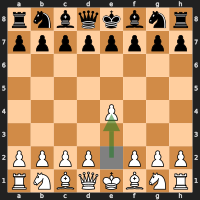

Player Black (Proxy) (to Player White):

Player Black (Proxy) (to Player White):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

Player Black, I've moved my pawn from e2 to e4. Your turn.

--------------------------------------------------------------------------------
Player White (Proxy) (to Player Black):

Player Black, I've moved my pawn from e2 to e4. Your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

***** Suggested tool Call (call_8k4xRy82X3FHWUorpBxiEiry): get_legal_moves *****
Arguments: 
{
  "player_color": "black"
}
********************************************************************************

------------------------------------------------------

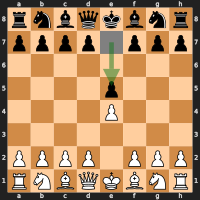

Player White (Proxy) (to Player Black):

Player White (Proxy) (to Player Black):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

Player White, I've moved my pawn from e7 to e5. It's your turn.

--------------------------------------------------------------------------------
Player Black (Proxy) (to Player White):

Player White, I've moved my pawn from e7 to e5. It's your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

***** Suggested tool Call (call_gGUgZZyv4tUWJO09HTvxbRLe): get_legal_moves *****
Arguments: 
{
  "player_color": "white"
}
********************************************************************************

--------------------------------------------

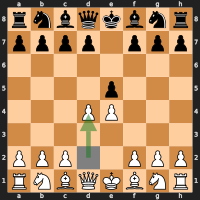

Player Black (Proxy) (to Player White):

Player Black (Proxy) (to Player White):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

Player Black, I've moved my pawn from d2 to d4. Your move.

--------------------------------------------------------------------------------
Player White (Proxy) (to Player Black):

Player Black, I've moved my pawn from d2 to d4. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

***** Suggested tool Call (call_BDKdzl6QRJFH8eNuoLaY8qKy): get_legal_moves *****
Arguments: 
{
  "player_color": "black"
}
********************************************************************************

------------------------------------------------------

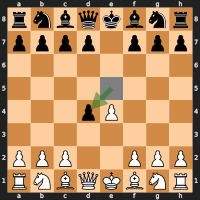

Player White (Proxy) (to Player Black):

Player White (Proxy) (to Player Black):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

Player White, I've moved my pawn from e5 to d4. Your move.

--------------------------------------------------------------------------------
Player Black (Proxy) (to Player White):

Player White, I've moved my pawn from e5 to d4. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

***** Suggested tool Call (call_Tfx8vpYucLB24zk55ac0YAEk): get_legal_moves *****
Arguments: 
{
  "player_color": "white"
}
********************************************************************************

------------------------------------------------------

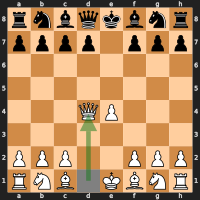

Player Black (Proxy) (to Player White):

Player Black (Proxy) (to Player White):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

Player Black, I've moved my queen from d1 to d4. Your move.

--------------------------------------------------------------------------------
Player White (Proxy) (to Player Black):

Player Black, I've moved my queen from d1 to d4. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

***** Suggested tool Call (call_QKaWiwtuSJ3ijpYs6dFsJOci): get_legal_moves *****
Arguments: 
{
  "player_color": "black"
}
********************************************************************************

----------------------------------------------------

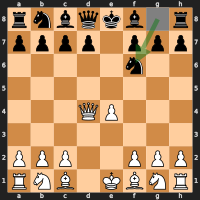

Player White (Proxy) (to Player Black):

Player White (Proxy) (to Player Black):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

Player White, I've moved my knight from g8 to f6. It's your turn.

--------------------------------------------------------------------------------
Player Black (Proxy) (to Player White):

Player White, I've moved my knight from g8 to f6. It's your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

***** Suggested tool Call (call_egaxvvrKvpbFlivVB3EMauFp): get_legal_moves *****
Arguments: 
{
  "player_color": "white"
}
********************************************************************************

----------------------------------------

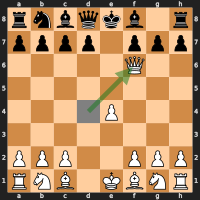

Player Black (Proxy) (to Player White):

Player Black (Proxy) (to Player White):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

Player Black, I've moved my queen from d4 to f6. Your move.

--------------------------------------------------------------------------------
Player White (Proxy) (to Player Black):

Player Black, I've moved my queen from d4 to f6. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

***** Suggested tool Call (call_lFtQRWv3tLMToC2KNcaV7qCY): get_legal_moves *****
Arguments: 
{
  "player_color": "black"
}
********************************************************************************

----------------------------------------------------

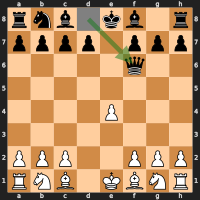

Player White (Proxy) (to Player Black):

Player White (Proxy) (to Player Black):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

Player White, I've moved my queen from d8 to f6. Your move.

--------------------------------------------------------------------------------
Player Black (Proxy) (to Player White):

Player White, I've moved my queen from d8 to f6. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

***** Suggested tool Call (call_iHyAga7j3Mu7xACYkZtoB63q): get_legal_moves *****
Arguments: 
{
"player_color": "white"
}
********************************************************************************

------------------------------------------------------

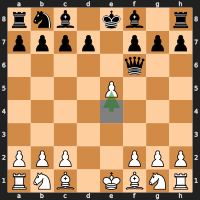

Player Black (Proxy) (to Player White):

Player Black (Proxy) (to Player White):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

Player Black, I've moved my pawn from e4 to e5. Your turn.

--------------------------------------------------------------------------------
Player White (Proxy) (to Player Black):

Player Black, I've moved my pawn from e4 to e5. Your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

***** Suggested tool Call (call_7zi7vvxY7P1I6TXFizzB5tte): get_legal_moves *****
Arguments: 
{
  "player_color": "black"
}
********************************************************************************

------------------------------------------------------

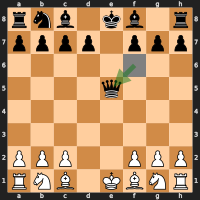

Player White (Proxy) (to Player Black):

Player White (Proxy) (to Player Black):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

Player White, I've moved my knight from f6 to e5. Your move.

--------------------------------------------------------------------------------
Player Black (Proxy) (to Player White):

Player White, I've moved my knight from f6 to e5. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

***** Suggested tool Call (call_AOK3uIihHIVnb1T2QweVKkEl): get_legal_moves *****
Arguments: 
{
  "player_color": "white"
}
********************************************************************************

--------------------------------------------------

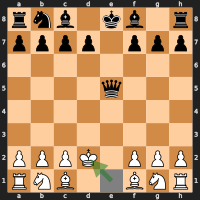

Player Black (Proxy) (to Player White):

Player Black (Proxy) (to Player White):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

Player Black, I've moved my king from e1 to d2. Your move.

--------------------------------------------------------------------------------
Player White (Proxy) (to Player Black):

Player Black, I've moved my king from e1 to d2. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

***** Suggested tool Call (call_9SlzyctkmaitlQNX4m2tmshN): get_legal_moves *****
Arguments: 
{
  "player_color": "black"
}
********************************************************************************

------------------------------------------------------

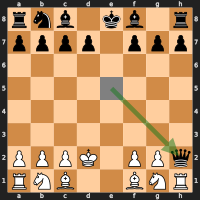

Player White (Proxy) (to Player Black):

Player White (Proxy) (to Player Black):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

Player White, I've moved my queen from e5 to h2. Your move.

--------------------------------------------------------------------------------
Player Black (Proxy) (to Player White):

Player White, I've moved my queen from e5 to h2. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

***** Suggested tool Call (call_sUp07oYsEMrA5IgWpplXqcxv): get_legal_moves *****
Arguments: 
{
  "player_color": "white"
}
********************************************************************************

----------------------------------------------------

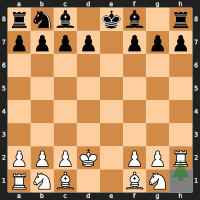

Player Black (Proxy) (to Player White):

Player Black (Proxy) (to Player White):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

Player Black, I've moved my rook from h1 to h2, capturing your queen. Your move.

--------------------------------------------------------------------------------
Player White (Proxy) (to Player Black):

Player Black, I've moved my rook from h1 to h2, capturing your queen. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

***** Suggested tool Call (call_AsV7KifYAwFeXNlBYWYiPS3S): get_legal_moves *****
Arguments: 
{
  "player_color": "black"
}
********************************************************************************

----------

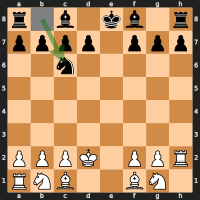

Player White (Proxy) (to Player Black):

Player White (Proxy) (to Player Black):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

Player White, I've moved my knight from b8 to c6. Your move.

--------------------------------------------------------------------------------
Player Black (Proxy) (to Player White):

Player White, I've moved my knight from b8 to c6. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

***** Suggested tool Call (call_iWvVjGc7lHZUkx0LrBKuAcVM): get_legal_moves *****
Arguments: 
{
  "player_color": "white"
}
********************************************************************************

--------------------------------------------------

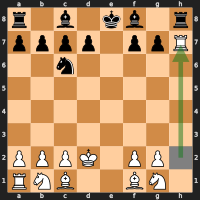

Player Black (Proxy) (to Player White):

Player Black (Proxy) (to Player White):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

Player Black, I've moved my rook from h2 to h7. Your move.

--------------------------------------------------------------------------------
Player White (Proxy) (to Player Black):

Player Black, I've moved my rook from h2 to h7. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

***** Suggested tool Call (call_gZ4A5zCAVtwwQVvnsyyjcSWE): get_legal_moves *****
Arguments: 
{
  "player_color": "black"
}
********************************************************************************

------------------------------------------------------

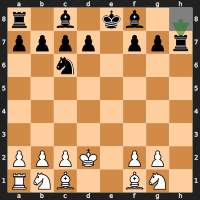

Player White (Proxy) (to Player Black):

Player White (Proxy) (to Player Black):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

Player White, I've moved my rook from h8 to h7. Your move.

--------------------------------------------------------------------------------
Player Black (Proxy) (to Player White):

Player White, I've moved my rook from h8 to h7. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

***** Suggested tool Call (call_nKn2yPngdytgagDFHmTftwob): get_legal_moves *****
Arguments: 
{
  "player_color": "white"
}
********************************************************************************

------------------------------------------------------

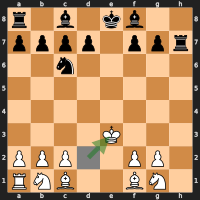

Player Black (Proxy) (to Player White):

Player Black (Proxy) (to Player White):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

Player Black, I've moved my pawn from d2 to e3. Your move.

--------------------------------------------------------------------------------
Player White (Proxy) (to Player Black):

Player Black, I've moved my pawn from d2 to e3. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

***** Suggested tool Call (call_EsrL6RbEWlIwRopnMb3GTLIY): get_legal_moves *****
Arguments: 
{
  "player_color": "black"
}
********************************************************************************

------------------------------------------------------

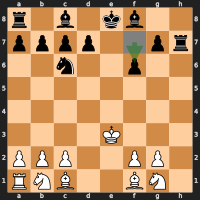

Player White (Proxy) (to Player Black):

Player White (Proxy) (to Player Black):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

Player White, I've moved my pawn from f7 to f6. It's your turn.

--------------------------------------------------------------------------------
Player Black (Proxy) (to Player White):

Player White, I've moved my pawn from f7 to f6. It's your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

***** Suggested tool Call (call_WKosExUyBCEdWIZABlXFKSN0): get_legal_moves *****
Arguments: 
{
  "player_color": "white"
}
********************************************************************************

--------------------------------------------

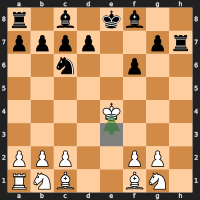

Player Black (Proxy) (to Player White):

Player Black (Proxy) (to Player White):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Player Black (Proxy)):

Player Black, I've moved my pawn from e3 to e4. It's your turn.

--------------------------------------------------------------------------------
Player White (Proxy) (to Player Black):

Player Black, I've moved my pawn from e3 to e4. It's your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

***** Suggested tool Call (call_oeqzKBgai26QiyfVpcknvbTN): get_legal_moves *****
Arguments: 
{
  "player_color": "black"
}
********************************************************************************

--------------------------------------------

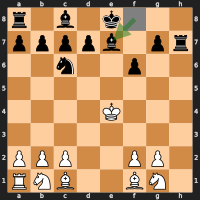

Player White (Proxy) (to Player Black):

Player White (Proxy) (to Player Black):

***** Response from calling tool "make_move" *****
MOVE MADE
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Player White (Proxy)):

Player White, I've moved my bishop from f8 to e7. Your turn.

--------------------------------------------------------------------------------


In [24]:
black = Chat(proxy_white, player_black)
white = Chat(proxy_black, player_white, max_consecutive_auto_reply=10)
black.initiate_chat(white, {"content": "Let's start playing.", "role": "user"})